<a href="https://colab.research.google.com/github/danshaub/Spectography/blob/main/Music_Spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

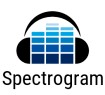
---
Analysis of music genre recognition & affective music classification
---
*Robert Farmer, Charles Filce, Dan Haub*


When loading the data used to train and test this model, it is significantly faster to mount a google drive folder and load from there. The folder used is linked [here](https://drive.google.com/drive/folders/1LB8V--17Dn8wfPXfYnsM9JH1Mtkblt8L?usp=sharing), which you can copy to your personal drive account. Otherwise, loading the data from the project GitHub repository is possible, but very slow. Wherever a specific drive folder is referenced, it may be necessary to edit the path.

There are two copies of each cell that loads data. One copy is set to pull the data from git hub and the other is set to pull the data from a mounted google drive. They are marked accordingly.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import gzip

from scipy import signal
from scipy.fft import fftshift

# Get file object for spectrogram data. 
# Takes label and file name as params
def getFile(label,name, from_git=False):
  if from_git:
    file = r'https://github.com/danshaub/Spectography/blob/main/data/fma_genre_spectrograms/'
    file += label + '/' + name + '?raw=true'
    return(urllib.request.urlopen(file))
  else:
    file = r'/content/drive/MyDrive/fma_genre_spectrograms/'    # Edit path to Google Drive folder if necessary
    file += label + '/' + name
    return(open(file, "rb"))


# Get an ndarray of spectrogram data.
# Takes either a file name, file object, or a tuple in the form (lable, fileName) anr 
def openSpec(fileName=None, fileObj=None, attr=None, from_git=False):
  if attr:
    fileObj = getFile(attr[0],attr[1], from_git=from_git)
  with gzip.GzipFile(filename=fileName, fileobj=fileObj, mode='r') as f:
    spec = np.flip(np.load(f)[:128], 0)
    fileObj.close()
    return spec

# Displays spectrogram for a given song
# Takes an ndarray of spectrogram data and a compression value
# Compresses image by a factor of 2^compression
def viewSpec(spec, compression=3):
  plt.figure(figsize = (spec.shape[1]/(2**compression), spec.shape[0]/(2**compression)))
  plt.imshow(spec, interpolation='nearest', aspect='auto')
  plt.set_cmap('nipy_spectral')
  plt.axis('off')
  plt.show()

# Splits each spectrogram into a list of smaller spectrograms
# Each element of the list is a numpy array of shape (128, 256)
def splitSpec(spec):
  frames = []
  for i in range(0, spec.shape[1], 256):
    frame = spec[:,i:i+256]
    if frame.shape[1] == 256:
      frames.append(frame)
  return frames

In [57]:
import pandas as pd

# Paths to csv files that map to each spectrogram file for the full set, training set, and test set
fullUrl = "https://raw.githubusercontent.com/danshaub/Spectography/main/data/full_set.csv"
trainUrl = "https://raw.githubusercontent.com/danshaub/Spectography/main/data/train_set.csv"
testUrl = "https://raw.githubusercontent.com/danshaub/Spectography/main/data/test_set.csv"

# Imports csv files
full = pd.read_csv(fullUrl)
train = pd.read_csv(trainUrl)
test = pd.read_csv(testUrl)

# Generates dictionary to convert from an label to an index
i = 0
labIndices = {}
for lab in test.Label.unique():
  labIndices[lab] = i
  i += 1

# Generates dictionary to convert from a label index to a label
getLab = {}
for lab in labIndices:
  getLab[labIndices[lab]] = lab

### Mounted Drive

Label                       Hip-Hop
FileName    18219.fused.full.npy.gz
Name: 1056, dtype: object


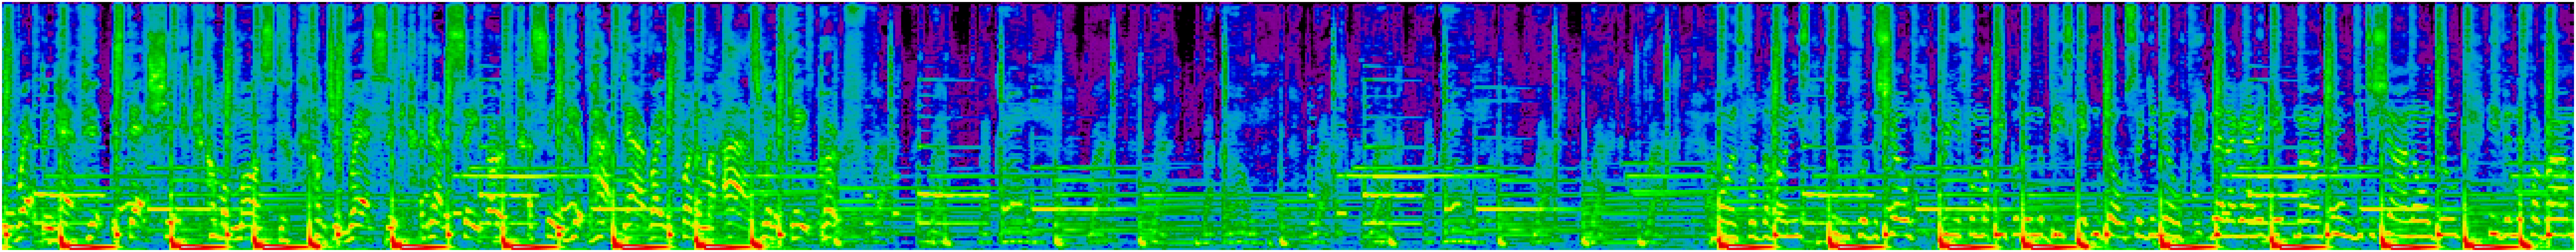

In [5]:
import random

# Picks a random spectrogram
indx = random.randint(0, len(full)-1)
row = full.iloc[indx]

print(row)

# Opens the spectrogram and displays it
spec = openSpec(attr=(row['Label'],row['FileName']))
viewSpec(spec)

### GitHub

Label                       Hip-Hop
FileName    18219.fused.full.npy.gz
Name: 1056, dtype: object


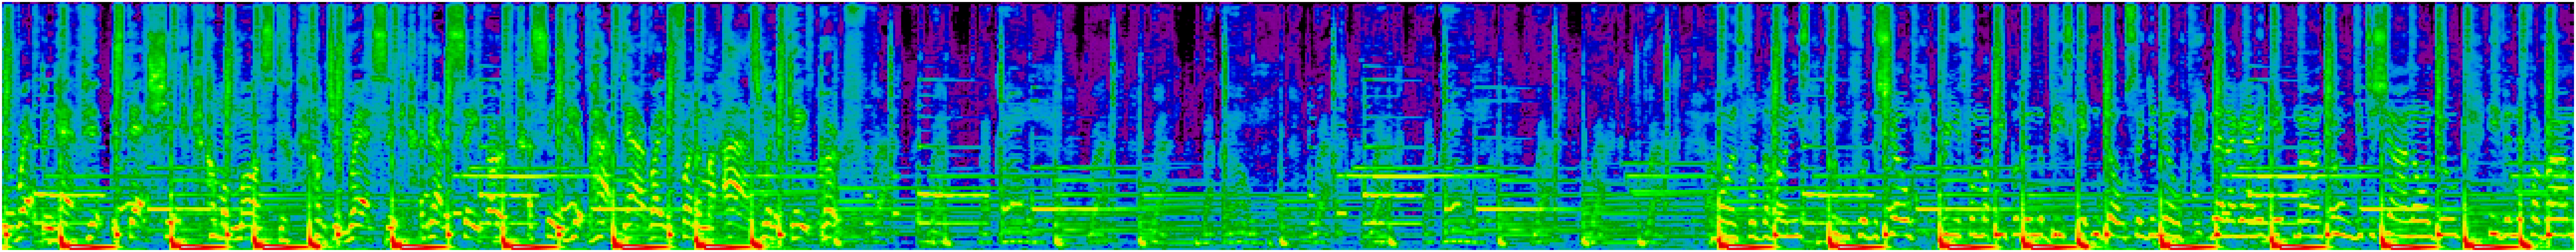

In [ ]:
import random

# Picks a random spectrogram
indx = random.randint(0, len(full)-1)
row = full.iloc[indx]

print(row)

# Opens the spectrogram and displays it
spec = openSpec(attr=(row['Label'],row['FileName']), from_git=True)
viewSpec(spec)

### Mounted Drive

In [ ]:
trainDataList = []
trainLabsList = []

# Populates list of spectrograms and labels
for i in range(len(train)):
  tempDat = openSpec(attr=(train.Label[i],train.FileName[i]))
  frames = splitSpec(tempDat)

  # Converts string label into a one-hot encoding
  oneHot = np.zeros((len(labIndices),))
  oneHot[labIndices[train.Label[i]]] = 1
  
  trainLabsList += ([oneHot] * len(frames))
  trainDataList += frames

### GitHub

In [ ]:
trainDataList = []
trainLabsList = []

# Populates list of spectrograms and labels for training data
for i in range(len(train)):
  tempDat = openSpec(attr=(train.Label[i],train.FileName[i]), from_git=True)
  frames = splitSpec(tempDat)

  # Converts string label into a one-hot encoding
  oneHot = np.zeros((len(labIndices),))
  oneHot[labIndices[train.Label[i]]] = 1
  
  trainLabsList += ([oneHot] * len(frames))
  trainDataList += frames

In [8]:
# Casts lists of data into a three dimensional ndarray
trainData = np.array(trainDataList)
trainData = trainData.reshape(trainData.shape + (1,))
trainLabs = np.array(trainLabsList)

In [9]:
# Deletes unnecessary lists
del trainDataList
del trainLabsList

### Mounted Drive

In [ ]:
testDataList = []
testLabsList = []
testFiles = []

# Populates list of spectrograms and labels for testing data
for i in range(len(test)):
  tempDat = openSpec(attr=(test.Label[i],test.FileName[i]))
  frames = splitSpec(tempDat)

  # Converts string label into a one-hot encoding
  oneHot = np.zeros((len(labIndices),))
  oneHot[labIndices[test.Label[i]]] = 1
  
  testLabsList += ([oneHot] * len(frames))
  testDataList += frames
  testFiles += ([test.FileName[i]] * len(frames))
  print(i)

### GitHub

In [ ]:
testDataList = []
testLabsList = []
testFiles = []

# Populates list of spectrograms and labels for testing data
for i in range(len(test)):
  tempDat = openSpec(attr=(test.Label[i],test.FileName[i]), from_git=True)
  frames = splitSpec(tempDat)

  # Converts string label into a one-hot encoding
  oneHot = np.zeros((len(labIndices),))
  oneHot[labIndices[test.Label[i]]] = 1
  
  testLabsList += ([oneHot] * len(frames))
  testDataList += frames
  testFiles += ([test.FileName[i]] * len(frames))
  print(i)

In [54]:
# Casts lists of data into a three dimensional ndarray
testData = np.array(testDataList)
testData = testData.reshape(testData.shape + (1,))
testLabs = np.array(testLabsList)

In [55]:
# Deletes unnecessary lists
del testDataList
del testLabsList

In [14]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=(128, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(20, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 253, 16)      272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 126, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 123, 32)       8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 27, 128)       7

In [15]:
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model.fit(trainData, trainLabs,validation_split = 0.2, batch_size= 32, epochs = 15)

# model.save('/content/drive/MyDrive/fma_genre_spectrograms/modelWeights.h5')

Epoch 1/15
384/384 [==============================] - 390s 1s/step - loss: 3.3575 - acc: 0.0794 - val_loss: 2.6878 - val_acc: 0.1554
Epoch 2/15
384/384 [==============================] - 385s 1s/step - loss: 2.6886 - acc: 0.1735 - val_loss: 2.5464 - val_acc: 0.2170
Epoch 3/15
384/384 [==============================] - 397s 1s/step - loss: 2.5490 - acc: 0.2205 - val_loss: 2.5967 - val_acc: 0.2131
Epoch 4/15
384/384 [==============================] - 397s 1s/step - loss: 2.4325 - acc: 0.2571 - val_loss: 2.4360 - val_acc: 0.2542
Epoch 5/15
384/384 [==============================] - 384s 1s/step - loss: 2.3299 - acc: 0.2913 - val_loss: 2.4733 - val_acc: 0.2594
Epoch 6/15
384/384 [==============================] - 380s 990ms/step - loss: 2.2356 - acc: 0.3204 - val_loss: 2.4658 - val_acc: 0.2711
Epoch 7/15
384/384 [==============================] - 371s 967ms/step - loss: 2.1233 - acc: 0.3480 - val_loss: 2.4572 - val_acc: 0.2594
Epoch 8/15
384/384 [==============================] - 369s 960m

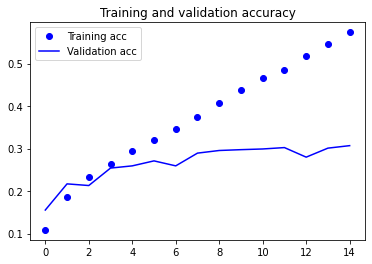

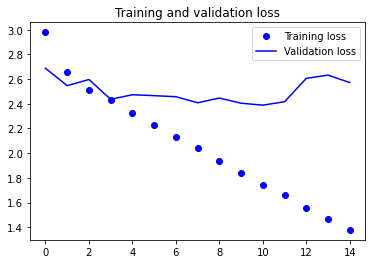

In [20]:
import matplotlib.pyplot as plt

# Displays model results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Mounted Drive

In [ ]:
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/fma_genre_spectrograms/modelWeights.h5')
# model.summary()

### GitHub

In [ ]:
# from keras.models import load_model
# model = load_model('https://github.com/danshaub/Spectography/blob/main/results/modelWeights.h5?raw=true')
# model.summary()

In [9]:
testPred = model.predict(testData)
testLoss, testAcc = model.evaluate(testData, testLabs)

120/120 [==============================] - 32s 263ms/step - loss: 2.6022 - acc: 0.2944


In [ ]:
# Transforms model prediction to one-hot encoding
for i in range(testPred.shape[0]):
  maxPredIndx = 0
  maxPred = 0
  for j in range(testPred.shape[1]):
    if testPred[i,j] > maxPred:
      maxPredIndx = j
      maxPred = testPred[i,j]
    testPred[i,j] = 0
  testPred[i,maxPredIndx] = 1
testPred

In [58]:
confMatrix = np.zeros((20,20))

missesTrue = []
missesPred = []
missesFile = []

# Generates data for confusion matrix and a data frame of incorrect predictions
for i in range(testLabs.shape[0]):
  trueIndx = -1
  guessIndx = -1

  for j in range(testLabs.shape[1]):
    if testLabs[i,j] == 1: trueIndx = j
    if test_pred[i,j] == 1: guessIndx = j

    if trueIndx >= 0 and guessIndx >= 0: break

  confMatrix[trueIndx, guessIndx] += 1

  if trueIndx != guessIndx:
    missesTrue.append(getLab[trueIndx])
    missesPred.append(getLab[guessIndx])
    missesFile.append(testFiles[i])

misses = pd.DataFrame({"True Label": missesTrue,
                       "Predicted Label": missesPred,
                       "File": missesFile})

# misses.to_csv('/content/drive/MyDrive/fma_genre_spectrograms/misses.csv')

# Regularizes each row of the confusion matrix
for i in range(confMatrix.shape[0]):
  rowSum = confMatrix[i].sum()
  for j in range(confMatrix.shape[1]):
    confMatrix[i,j] /= rowSum


Text(105.0, 0.5, 'True Label')

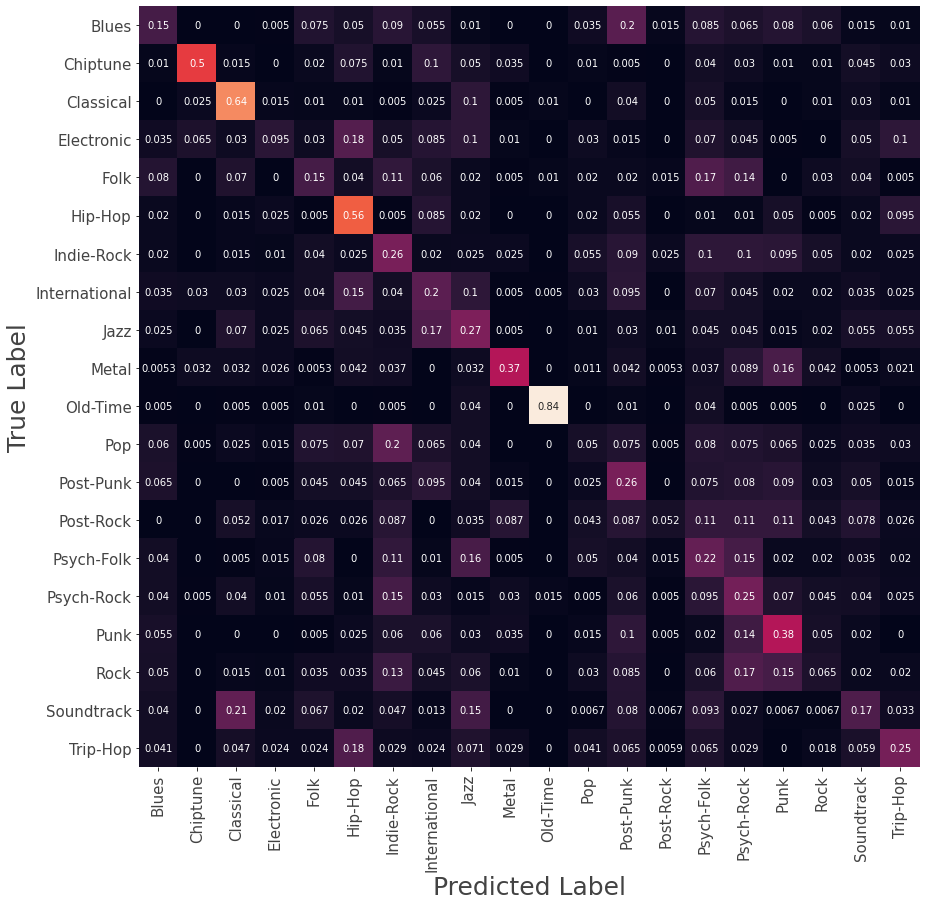

In [52]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Displays confusion matrix
confMatrixDf = pd.DataFrame(confMatrix, index = [i for i in labIndices.keys()],
                  columns = [i for i in labIndices.keys()])
plt.figure(figsize = (14,14))
hm = sn.heatmap(confMatrixDf, annot=True, cbar=False)

for label in hm.get_xticklabels():
  label.set_size(15)
for label in hm.get_yticklabels():
  label.set_size(15)

hm.set_xlabel("Predicted Label", fontsize=25)
hm.set_ylabel("True Label", fontsize=25)